In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras

import sys
# sys.path.append('/Users/tradergllc/github/tensorflow/src/')
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet_merge_cam
import dense

Using TensorFlow backend.


In [2]:
model_root = ['densenet_triplet_cam_block2_3', 'densenet_triplet_cam_end']

In [3]:
ip = 'ec2-52-14-4-98.us-east-2.compute.amazonaws.com'

In [4]:
download = "scp -i /home/albert/aws/ec2-ubuntu.pem ubuntu@%s:albert/models/%s/%s_%d.h5 /home/albert/github/tensorflow/models/%s/"

In [5]:
for m in model_root:
    if os.path.exists('/home/albert/github/tensorflow/models/%s' % m) == False:
        os.system('mkdir /home/albert/github/tensorflow/models/%s' % m)

In [6]:
CAFFE_ROOT = '/home/albert/github/tensorflow/'
# CAFFE_ROOT = '/Users/tradergllc/github/tensorflow/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [7]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

In [8]:
test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

In [9]:
input_shape = (256,128)

overlay = True
overlay_eval = True
preprocess = True

In [10]:
def plot_score(score):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance']
    neg_distance = score['neg_distance']
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(score['recall'], score['precision'])
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    
    plt.show()

    print score['rank']

In [11]:
train_score = {'densenet_triplet_cam_block2_3' : {} , 'densenet_triplet_cam_end' : {}}
test_score = {'densenet_triplet_cam_block2_3' : {} , 'densenet_triplet_cam_end' : {}}

0
8 4
Weights for the model were loaded successfully
densenet_triplet_cam_block2_3
train 2000


KeyError: 'pos_distance'

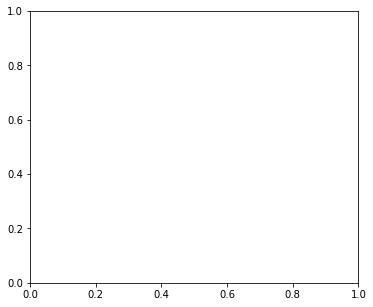

In [13]:
while True:
    iterations = [2000, 1000]
    for i in range(len(model_root)):
        d = os.system(download % (ip, model_root[i], model_root[i], iterations[i], model_root[i]))
        print d
        if d == 0:
            model_path = model_root[i] + '_' + str(iterations[i]) + '.h5'
            if i == 0:
                trinet = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), 
                                                   cam_placement=[2])
            elif i == 1:
                trinet = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), cam_placement=[3])
            trinet.load_weights('/home/albert/github/tensorflow/models/%s/%s' % (model_root[i], model_path))
            
            train_score[model_root[i]][iterations[i]] = {} #triplet_merge_cam.get_score(trinet, train_dict, train_files, hist=None, 
                                                            #      overlay=overlay, train=True, preprocess=preprocess,
                                                             #     shape=input_shape)
            print model_root[i]
            print 'train' , iterations[i]
            plot_score(train_score[model_root[i]][iterations[i]])

            test_score[model_root[i]][iterations] = {} #triplet_merge_cam.get_score(trinet, test_dict, test_files, hist=None, 
                                                        #         overlay=overlay, train=False, preprocess=preprocess,
                                                         #        shape=input_shape)
            print model_root[i]
            print 'test', iterations[i]
            plot_score(test_score[model_root[i]][iterations[i]])

            iterations[i] += 1000
        else:
            if i == 1:
                time.sleep(300)
            continue

In [ ]:
for m in model_root:
    np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (m, m), train_score[m])
    np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (m, m), test_score[m])

In [15]:
download % (ip, model_root[0], model_root[0], iterations[0], model_root[0])

'scp -i /home/albert/aws/ec2-ubuntu.pem ubuntu@ec2-52-14-4-98.us-east-2.compute.amazonaws.com:albert/models/densenet_triplet_cam_block2_3/densenet_triplet_cam_block2_3_2000.h5 /home/albert/github/tensorflow/models/densenet_triplet_cam_block2_3/'